In [1]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2024-11-14 16:53:33


In [2]:
from pynext.system_of_units import *

In [3]:
from pynext.Material import PhysicalMaterial
from pynext.PhysicalVolume import PhysicalVolume
from pynext.Shapes import Cylinder, CylinderShell, FlatPlate

In [4]:
from pynext.xetd import Xenon, CXe

In [5]:
from pynext.geometry import draw_cylinder, draw_2cylinder, draw_2cylynder_surface
from pynext.geometry import Cylinder as GCylinder
from pynext.geometry import vectors_spherical
from pynext.geometry import Ray, ray_intersection_with_cylinder
from pynext.geometry import generate_and_transport_gammas_lxe_shell, generate_and_transport_gammas_gxe_shell
from pynext.geometry import generate_and_transport_gammas_lxe_endcaps
from pynext.histograms import h1d

In [6]:
from pynext.CylindricalVessel import  CVD
from pynext.CylindricalVessel import  CylindricalVessel
from pynext.Material import  cu12, cu03
from pynext.activity_functions import  activity_of_CV, print_activity_of_CV

In [7]:
from pynext.energy import gaussian, integrate_gaussian_from_x0
from pynext.energy import plot_gaussians, energy_window_eff, energy_window_fom

In [19]:
from pynext.Shapes import  Sphere, SphereShell

# Toy LSXe Detector

- The goal of this exercize is to compute the irreducible background due to the Bi-214 activity in the inner baloon of KamLAND-Zen. 

- Our toy detector is extremely simple. The vessel is a sphere made of nylon with a radius of 1.9 m. We assume that all external backgrounds to that sphere are shielded by the outer shell of LXe. We will define a physics sphere as a volume of R = 1.57 m (following KamLAND-Zen2). But of course, we can trade mass for background reducing the radius of the physics sphere

- We also need to know the total (photoelectric) interaction cross section in liquid scintillator (assuming the bulk of the scintillator is pseudoocumene, C$_9$H$_{12}$. These data are available from
[NIST](https://physics.nist.gov/cgi-bin/Xcom/xcom3_1) 

- The calculation itself is straight forward.
    - Compute the activity of Bi-214 in the baloon.
    - Obtain the number of gammas with energies 2.448 MeV emitted by Bi-214 (1.5 %, see [here](https://www.nndc.bnl.gov/nudat3/decaysearchdirect.jsp?nuc=214Bi&unc=NDS)
    - Propagate these gammas to the physics region.
    - Weight the distance they travel by the attenuation factor $e^{-d/L_{att}}$, where $L_{att}$ can be computed from the NIST data.
    - Multiply by the photoelectric fraction.

- This is just a simple (toy!) calculation, intended to illustrate the basic aspects of the game, all bb0nu experiments have sophisticated background models and hyper-tuned Monte Carlos to make a precise prediction of backgrounds. 
  


## Physics

In [8]:
def mu_vs_e(npdata):
    return npdata[:,0] * MeV, npdata[:,1] * (cm2/g)

In [9]:
def mu_vs_e_phot(npdata):
    return npdata[:,0] * MeV, npdata[:,1] * (cm2/g), npdata[:,2] * (cm2/g)

In [10]:
def get_murho(energy, mu_over_rho_phot, mu_over_rho_tot):
    def get_murho_at_energy():
        for i, e in enumerate(energy):
            if energy[i] == 2.5:
                break
        return mu_over_rho_phot[i], mu_over_rho_tot[i]
    return get_murho_at_energy()

In [11]:
xphot= np.loadtxt('xsect_c9h12.csv', comments='#')

In [12]:
energy, mu_over_rho_phot, mu_over_rho_tot = mu_vs_e_phot(xphot)

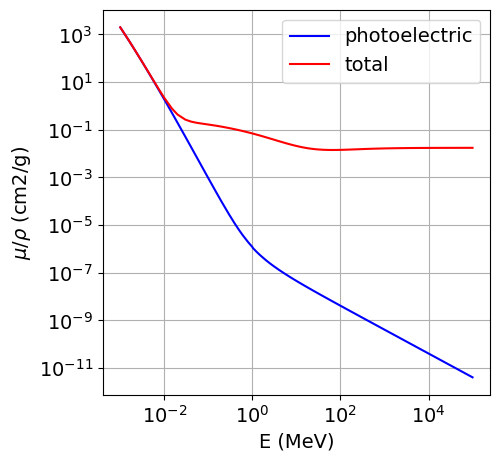

In [13]:
fig = plt.figure(figsize=(5,5))
plt.loglog(energy / MeV, mu_over_rho_phot / (cm2/g),'b', label='photoelectric')
plt.loglog(energy / MeV, mu_over_rho_tot / (cm2/g),'r', label='total')
plt.grid(True)
plt.xlabel('E (MeV)')
plt.ylabel(r'$\mu/\rho$ (cm2/g)')
plt.legend()
#plt.text(0.005, 1000, r'photoelectric $\mu/\rho$ for xenon')
plt.show()

In [14]:
rhols = 0.88 * g/cm3
murho_phot_2447, murho_tot_2447 = get_murho(energy, mu_over_rho_phot, mu_over_rho_tot)
xPheTot = murho_phot_2447/murho_tot_2447
muxe_2447 = murho_tot_2447 * rhols
latt_2447 = 1/muxe_2447

In [15]:
print(f"mu/rho (tot) = {murho_tot_2447/(cm2/g)} cm2/g")
print(f"Photoelectric fraction = {xPheTot}")
print(f"Latt in LS (2447 keV gammas) = {latt_2447/cm} cm")

mu/rho (tot) = 0.04316 cm2/g
Photoelectric fraction = 5.750695088044487e-06
Latt in LXe (2447 keV gammas) = 26.329092594152844 cm


## Dimensions
- The toy LXe detector that we will consider is an idealisation of nEXO. It consists of a radiopure copper vessel hosting a TPC. The dimensions are taken from nEXO CDR.


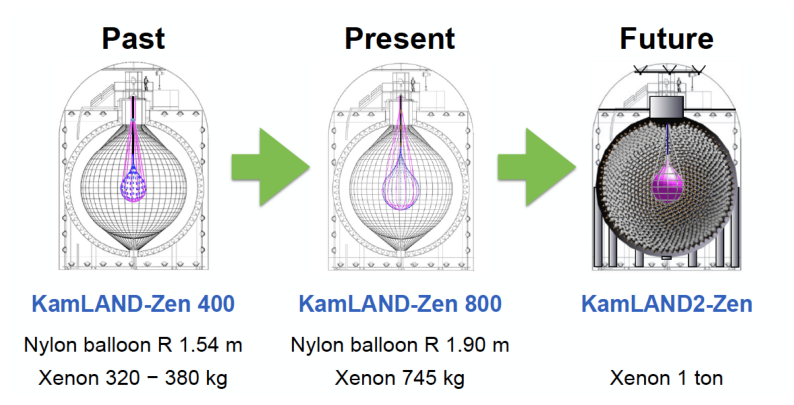

In [16]:
img = mpimg.imread('kzenPhases.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Define the detector

In [29]:
kz = SphereShell(Rin=1.57*m, Rout=1.9*m)

In [30]:
min = kz.inner_volume() * rhols
msh = kz.shell_volume() * rhols
print(f"Inner volume: mass = {min/ton} tons")
print(f"Full volume: mass = {msh/ton} tons")

Inner volume: mass = 14.264949504934847 tons
Full volume: mass = 11.01825306793942 tons


In [32]:
xd = kz.thickness()
print(f"average distance = {xd/cm} cm")

average distance = 33.0 cm


In [33]:
wx = np.exp(-xd/latt_2447)
print(f"weight = {wx}")

weight = 0.2855419287210123


## Background of Bi-214 due to copper vessel. 

$$ R_{\gamma(2448 keV)}^{{}^{214}Bi} = A^{{}^{214}Bi} {\rm [Bq]} \times BR^{{}^{214}Bi}_{\gamma(2448 keV)} = 1.55 \cdot 10^{-3} {\rm [cts/sec]} \times 1.5 \cdot 10^{-2}$$

$$ N_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~1 year} = R_{\gamma(2448 keV)}^{{}^{214}Bi} \times 3.1 \cdot 10^7 $$

$$ I_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = N_{\gamma(2448 keV)}^{{}^{214}Bi} \times f_{\gamma(2448 keV)}^{ROI} $$

$$ Phot_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = I_{\gamma(2448 keV)}^{{}^{214}Bi} \times 
\frac{\sigma_{phot}}{\sigma_{total}}(2448 keV) $$

$$ Sel_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = Phot_{\gamma(2448 keV)}^{{}^{214}Bi} \times 
\epsilon_{ROI} \times \epsilon_{topo} $$

### Bi-214 gamma (2448 keV)


In [34]:
brg = 1.5e-2           # BR of 2448 keV gamma
print(f"BR of 2448 keV gamma= {brg}")
print(f"Ratio of photoelectric to total cross section = {xPheTot}")

BR of 2448 keV gamma= 0.015
Ratio of photoelectric to total cross section = 5.750695088044487e-06


### Backgrounds in the Body

In [51]:
cs_body_activity_bi214_Bq = 36e-6 * Bq/kg * 
rg = cs_body_activity_bi214_Bq * brg
ng = rg * year/second
ig = ng * w_barrel
pg = ig * xPheTot
pse = pg * ebi 
pst = pse * etbi
print(f"rate of gammas of 2448 keV emitted by copper (self-shielded) = {rg}")
print(f"number of gammas of 2448 keV emitted by copper (one year) = {ng}")
print(f"number of gammas of 2448 keV interacting in fiducial volume = {ig}")
print(f"number of gammas of 2448 keV making a photoelectric in fiducial volume = {pg}")
print(f"number of gammas of 2448 keV selected = {ps}")
print(f"number of gammas of 2448 keV passing energy cut = {pse}")
print(f"number of gammas of 2448 keV passing topology cut = {pst}")

rate of gammas of 2448 keV emitted by copper (self-shielded) = 8.220443639647104e-05
number of gammas of 2448 keV emitted by copper (one year) = 2592.399106199111
number of gammas of 2448 keV interacting in fiducial volume = 1631.554366535987
number of gammas of 2448 keV making a photoelectric in fiducial volume = 36.194104721898086
number of gammas of 2448 keV selected = 0.001
number of gammas of 2448 keV passing energy cut = 5.450361507698204
number of gammas of 2448 keV passing topology cut = 0.053086521084980354


### Background due to end-caps is similar

### Signal efficiency
- The cost of the topological and energy cuts is 64\%.
- NB, the background rate is very small, one could tradeoff efficiency for background easily.  